In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os
import torch
from torch import nn, optim
import random
import matplotlib.pyplot as plt
from tqdm import trange

train_size = 12
predict_size = 4

In [117]:
# for local environment
# df = pd.read_pickle('working_dataset.pkl')

# for cloud environment
df = pd.read_csv('https://drive.google.com/uc?export=download&id='
 + '12fztRILR7EaGV-ipq_89AEAZAFUlyjUx')

data = df.iloc[:, 1:].values.astype(float)

In [118]:
# define the prediction be the % change of the prices
price_pct = [0]
for i in range(1, data.shape[0]):
    price_pct.append((data[i, 1] - data[i-1, 1])/data[i-1, 1])
price_pct = np.array(price_pct, dtype=float)
prices = data[:, 1].copy()
data[:, 1] = price_pct

# normalize the featres
normalized_features = MinMaxScaler().fit_transform(data[:, 2:])
X = np.hstack((normalized_features, np.array(price_pct).reshape(-1, 1)))
X = np.array([X[i-train_size:i, :].reshape(-1) for i in range(train_size, len(data)-predict_size)], dtype=np.float64)
y = np.array([price_pct[i:i+predict_size] for i in range(train_size, len(data)-predict_size)], dtype=np.float64)

X.shape, y.shape

((1526, 168), (1526, 4))

In [119]:
train_X, train_y = X[:int(0.6 * len(X))], y[:int(0.6 * len(y))]
valid_X, valid_y = X[int(0.6 * len(X)):int(0.8 * len(X))], y[int(0.6 * len(y)):int(0.8 * len(y))]
test_X, test_y = X[int(0.8 * len(X)):], y[int(0.8 * len(y)):]

In [120]:
# the basic linear regression model
model = LinearRegression().fit(train_X, train_y)
preds = model.predict(test_X)

print(f'Overall RMSE: {mean_squared_error(test_y, preds, squared=False)}\n')

for i in range(predict_size):
    print(f'RMSE-{i}: {mean_squared_error(test_y[:, i], preds[:, i], squared=False)}')

Overall RMSE: 13058150.302896548

RMSE-0: 18432413.307252865
RMSE-1: 774771.5286791826
RMSE-2: 16206909.979640787
RMSE-3: 16818506.396013353


In [125]:
# for local environment
# df = pd.read_pickle('working_dataset.pkl')

# for cloud environment
df = pd.read_csv('https://drive.google.com/uc?export=download&id='
 + '12fztRILR7EaGV-ipq_89AEAZAFUlyjUx')

data = df.iloc[:, 1:].values.astype(float)

In [126]:
# define the prediction be the % change of the prices
price_pct = [0]
for i in range(1, data.shape[0]):
    price_pct.append((data[i, 1] - data[i-1, 1])/data[i-1, 1])
price_pct = np.array(price_pct, dtype=float)
prices = data[:, 1].copy()
data[:, 1] = price_pct

# normalize the featres
normalized_features = MinMaxScaler().fit_transform(data[:, 2:])
X = np.hstack((normalized_features, np.array(price_pct).reshape(-1, 1)))
X = np.array([X[i-train_size:i, :] for i in range(train_size, len(data)-predict_size)], dtype=np.float64)
y = np.array([price_pct[i:i+predict_size] for i in range(train_size, len(data)-predict_size)], dtype=np.float64)

X.shape, y.shape

((1526, 12, 14), (1526, 4))

In [127]:
class Model(nn.Module):
    def __init__(self,hidden_size=32,num_layers=2,dropout=0.2):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(
            input_size=14,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, 4)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.fc(hn[0])
        return out

In [128]:
train_X, train_y = X[:int(0.6 * len(X))], y[:int(0.6 * len(y))]
valid_X, valid_y = X[int(0.6 * len(X)):int(0.8 * len(X))], y[int(0.6 * len(y)):int(0.8 * len(y))]
test_X, test_y = X[int(0.8 * len(X)):], y[int(0.8 * len(y)):]

In [78]:
# model = Model(hidden_size=64, num_layers=3, dropout=0.3)
model = Model(hidden_size=32, num_layers=1, dropout=0.2)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()

min_loss = float('inf')
count = 0

history = {'loss': [], 'val_loss':[]}

for epoch in trange(200):
    train_loss = 0.0

    for i in range(0, len(train_X), 16):
        output = model(torch.from_numpy(train_X[i:i+16]).float())
        loss = loss_function(output, torch.from_numpy(train_y[i:i+16]).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= (len(train_X)//16)
    history['loss'].append(train_loss)

    # validation
    with torch.no_grad():
        valid_loss = 0.0
        for i in range(0, len(valid_X), 16):
            output = model(torch.from_numpy(valid_X[i:i+16]).float())
            loss = loss_function(output, torch.from_numpy(valid_y[i:i+16]).float())
            valid_loss += loss.item()
    valid_loss /= (len(valid_X)//16)
    history['val_loss'].append(valid_loss)

    # early stopping
    if valid_loss > min_loss:
        count += 1
        if count > 9:
            break
    else:
        min_loss = valid_loss
        count = 0
        torch.save(model, 'best_model')
        
print(f'best score = {min_loss:.2e}')

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
 60%|█████▉    | 119/200 [00:30<00:20,  3.95it/s]

best score = 3.41e-04


In [79]:
model = torch.load('best_model')
with torch.no_grad():
    test_loss = 0.0
    for i in range(0, len(test_X), 16):
        output = model(torch.from_numpy(test_X[i:i+16]).float())
        loss = loss_function(output, torch.from_numpy(test_y[i:i+16]).float())
        test_loss += loss.item()
test_loss /= (len(test_X)//16)
print(f'test loss = {test_loss:.2e}')

test loss = 1.20e-03


Text(0, 0.5, 'Loss')

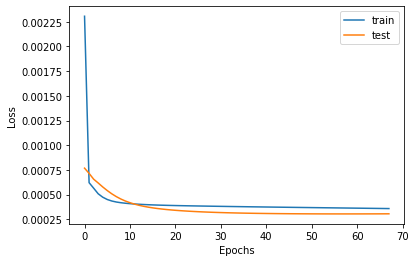

In [50]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.legend(["train", "test"], loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [129]:
# the lstm model
with torch.no_grad():
  preds = model(torch.from_numpy(test_X).float())

In [105]:
# the lstm model
with torch.no_grad():
  preds = model(torch.from_numpy(test_X).float())

print(f'Overall RMSE: {mean_squared_error(test_y, preds, squared=False)}\n')

for i in range(predict_size):
    print(f'RMSE-{i}: {mean_squared_error(test_y[:, i], preds[:, i], squared=False)}')

Overall RMSE: 0.03159138707124788

RMSE-0: 0.02021980737865225
RMSE-1: 0.04554196579734228
RMSE-2: 0.028326963240853705
RMSE-3: 0.0322768118681433


In [123]:
model = torch.load('best_model')

print(model)

Model(
  (lstm): LSTM(14, 32, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)


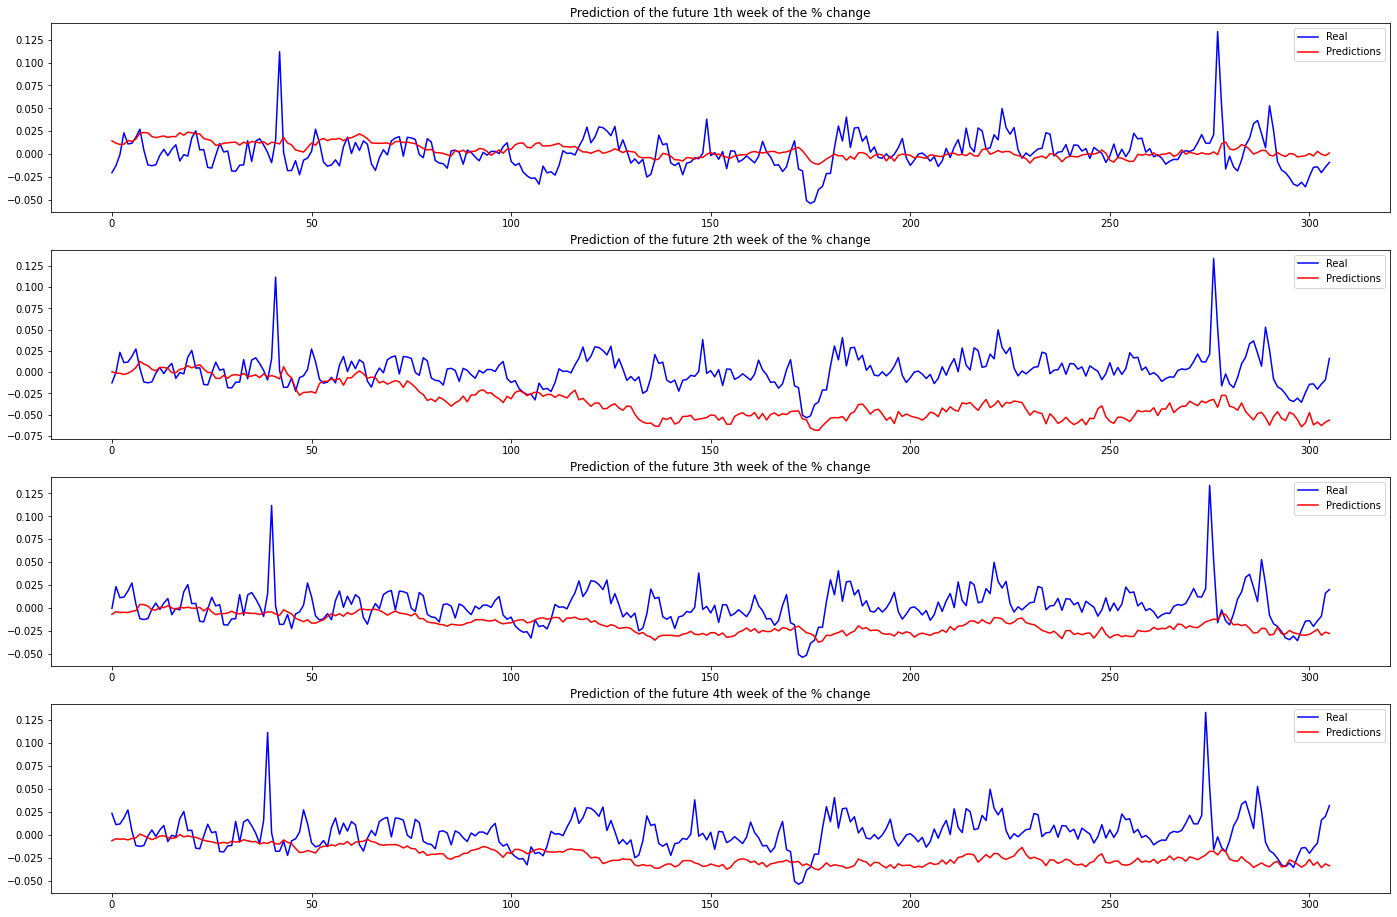

In [130]:
plt.figure(figsize=(24, 16))
for i in range(4):
    plt.subplot(predict_size, 1, i+1)
    plt.plot(range(len(test_y)), test_y[:, i], color='blue', label='Real')
    plt.plot(range(len(test_y)), preds[:, i], color='red', label='Predictions')
    plt.legend()
    plt.title(f'Prediction of the future {i+1}th week of the % change')
plt.show()

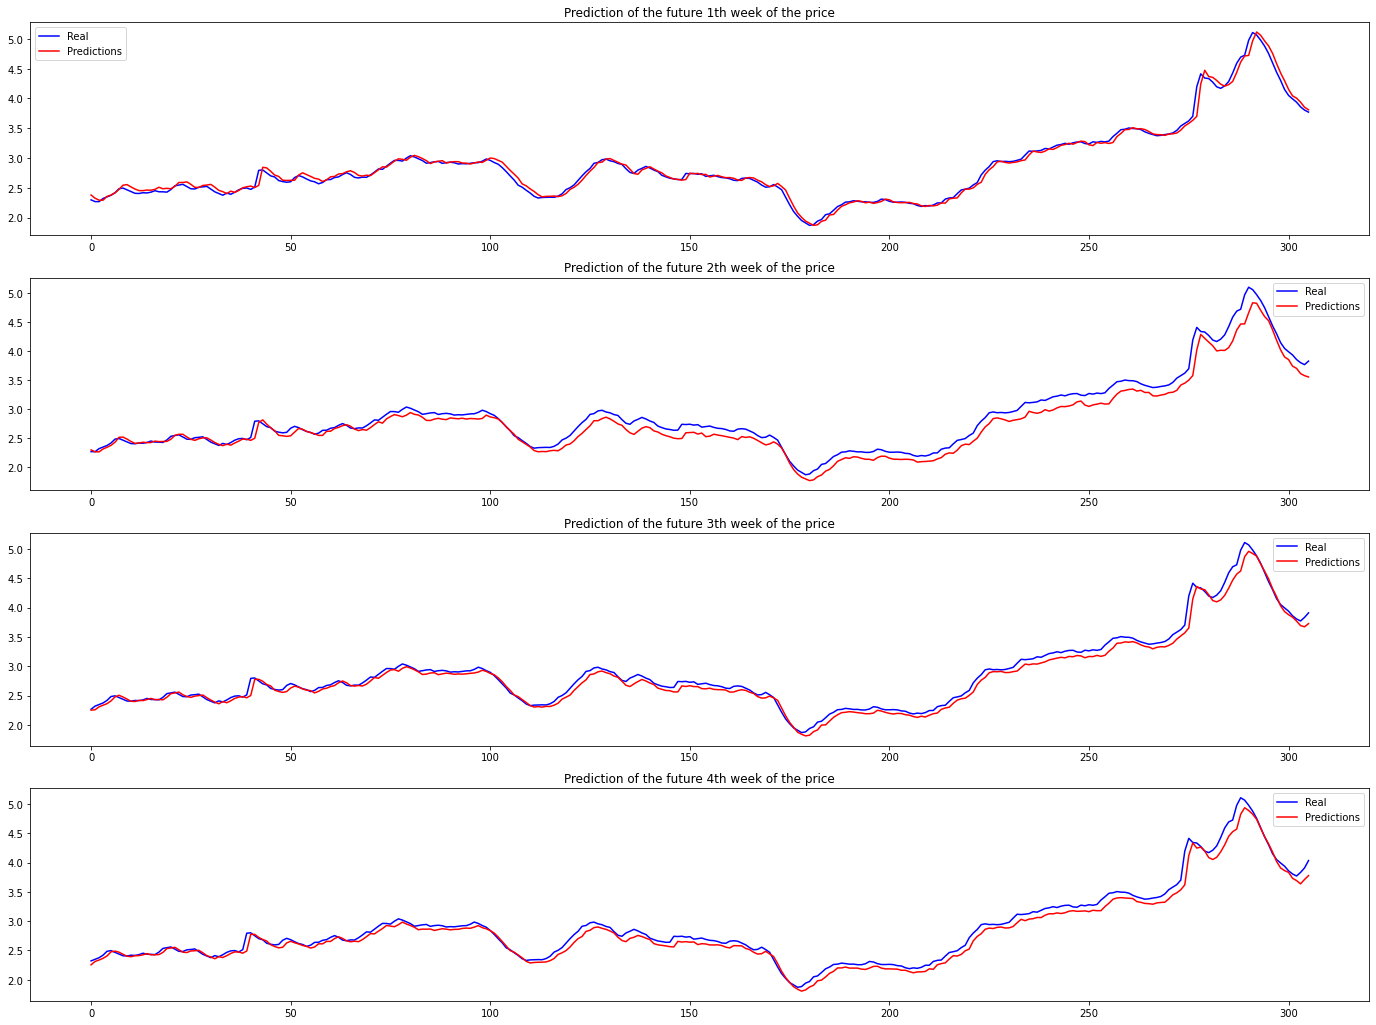

In [132]:
prices_transpose = np.array([prices[12+i:-4+i] for i in range(predict_size)], dtype=np.float64)
prices_transpose_test = prices_transpose[:, int(0.8 * len(X)):]
predicted_prices_transpose_temp = np.array([prices[11+i:-5+i] for i in range(predict_size)], dtype=np.float64)[:, int(0.8 * len(X)):]
predicted_prices_transpose_test = np.array([predicted_prices_transpose_temp[i] * (preds[:, i].numpy()+1) for i in range(predict_size)], dtype=np.float64)

plt.figure(figsize=(24, 18))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(range(len(test_y)), prices_transpose_test[i], color='blue', label='Real')
    plt.plot(range(len(test_y)), predicted_prices_transpose_test[i], color='red', label='Predictions')
    plt.legend()
    plt.title(f'Prediction of the future {i+1}th week of the price')
plt.show()